# Import dependancies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bz2

import neobase as nb

In [2]:
# windows file paths
#bookings_path = r'../../../data/challenge/bookings.csv.bz2'
#searches_path = r'../../../data/challenge/searches.csv.bz2'
# linux file paths
bookings_path = '../../data/challenge/bookings.csv.bz2'
searches_path = '../../data/challenge/searches.csv.bz2'

Since bookings file is 4.4Gb, we could use a sample to explore the data.

In [32]:
bookings_sample = pd.read_csv(bookings_path, compression='bz2', sep= '^', header=0, nrows = 100_000)
bookings_sample.to_csv('../../data/challenge/bookings_sample.csv', index=False)

# Explore the data available

In [4]:
sample_path = '../../data/challenge/bookings_sample.csv'
bookings_sample = pd.read_csv(sample_path)
bookings_sample.columns

Index(['act_date           ', 'source', 'pos_ctry', 'pos_iata', 'pos_oid  ',
       'rloc          ', 'cre_date           ', 'duration', 'distance',
       'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry',
       'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry',
       'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry',
       'intl', 'route          ', 'carrier', 'bkg_class', 'cab_class',
       'brd_time           ', 'off_time           ', 'pax', 'year', 'month',
       'oid      '],
      dtype='object')

Some columns seem to have a indefinite amount of white spaces.

In [5]:
bookings_sample.columns = [col.strip() for col in bookings_sample.columns]
bookings_sample

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,...,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,...,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,...,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,...,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,...,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,...,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-03-03 00:00:00,1G,FR,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,2013-02-28 00:00:00,11731,0,DEL,...,DELIXL,CH,N,Y,2013-05-02 05:40:00,2013-05-02 07:11:47,2,2013,3,NULL
99996,2013-03-05 00:00:00,1G,FR,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,2013-02-28 00:00:00,11731,0,DEL,...,DELIXL,CH,N,Y,2013-05-02 05:40:00,2013-05-02 07:11:47,-2,2013,3,NULL
99997,2013-03-05 00:00:00,1G,FR,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,2013-02-28 00:00:00,11731,0,DEL,...,IXLDEL,CH,Q,Y,2013-05-10 07:40:00,2013-05-10 09:11:47,-2,2013,3,NULL
99998,2013-03-20 00:00:00,1G,ZA,355368d5d743bd879313059478579059,a6dc7522954b518c8530ee2058ac946a,34ce3041cf21fe149b175c82dc991183,2013-03-20 00:00:00,4612,0,HLA,...,HLACPT,WX,O,Y,2013-06-14 14:55:00,2013-06-14 17:12:14,2,2013,3,NULL


We could also get rid of he spaces in some columns using loc

In [6]:
bookings_sample.loc[:,'arr_port'] = bookings_sample['arr_port'].str.strip()

Or we could rename all columns using a dictionary.

In [7]:
new_cols = {}
for col in bookings_sample.columns:
    new_cols[col] = col.strip()
bookings_sample = bookings_sample.rename(new_cols, axis=1)

# Exercise 1

Count the number of lines in python for each file

In order to do it as fast as possible we can select one column to count all lines.

bookings_lenght = len(pd.read_csv(
                                  bookings_path,
                                  compression='bz2', 
                                  sep= '^', 
                                  header=0, 
                                  usecols=['pax'], 
                                  ))
print(f'Bookings.csv has {bookings_lenght} lines.')

searches = pd.read_csv(
                       searches_path,
                       compression='bz2', 
                       sep= '^', 
                       header=0,
                       nrows=10
                       )
searches.columns

searches_lenght = len(pd.read_csv(
                                searches_path,
                                compression='bz2', 
                                sep= '^', 
                                header=0, 
                                usecols=['Date'],
                                ))
print(f'searches.csv has {searches_lenght} lines.')

# Exercise 2

Top 10 arrival airports in the world in 2013 (using the bookings file)

• Arrival airport is the column **arr_port**. It is the IATA code for the airport

• To get the total number of passengers for an airport, you can *sum* the column
**pax**, grouping by **arr_port**. Note that there is negative pax. That corresponds to
cancelations. So to get the total number of passengers that have actually
booked, you should sum including the negatives (that will remove the canceled
bookings).

• Print the top 10 arrival airports in the standard output, including the number of
passengers.

• Bonus point: Get the name of the city or airport corresponding to that airport
(programatically, we suggest to have a look at GeoBases in Github)

• Bonus point: Solve this problem using pandas (instead of any other approach)

In [11]:
df_full = pd.read_csv(
                     bookings_path,
                     compression='bz2', 
                     sep= '^', 
                     header=0, 
                     usecols=['arr_port', 'pax', 'year'], 
                     #nrows = 100000
                     chunksize=100_000 # con este parametro se convierte en un iterador
                    )

We load the dataset using chunks.

In [12]:
top_airports = []
with df_full as df_iter:
    for chunk in df_full:
        partial = chunk.groupby('arr_port')['pax'].sum()
        top_airports.append(partial)

top = pd.concat(top_airports, axis= 0)

top_10_arrival = top.groupby('arr_port').sum().sort_values(ascending=False).head(10).copy()

We loop through the data and extract the top airports by passengers. 

https://pypi.org/project/GeoBases/

In [13]:
top_10_arrival.index

Index(['LHR     ', 'MCO     ', 'LAX     ', 'LAS     ', 'JFK     ', 'CDG     ',
       'BKK     ', 'MIA     ', 'SFO     ', 'DXB     '],
      dtype='object', name='arr_port')

IATA codes are also spelled with spaces so we have to take them out before proceeding.

In [14]:
top_10_arrival.index = [ind.strip() for ind in top_10_arrival.index]

In [17]:
top_10_arrival

LHR    88809.0
MCO    70930.0
LAX    70530.0
LAS    69630.0
JFK    66270.0
CDG    64490.0
BKK    59460.0
MIA    58150.0
SFO    58000.0
DXB    55590.0
Name: pax, dtype: float64

In [20]:
b = nb.NeoBase()
top_10_arrival = pd.DataFrame(top_10_arrival)
top_10_arrival['city_name'] = 'a'
for i in top_10_arrival.index:
    top_10_arrival['city_name'][i] = b.get(i, 'name')

/tmp/ipykernel_1934/4103092669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_arrival['city_name'][i] = b.get(i, 'name')


In [21]:
top_10_arrival

,pax,city_name
LHR,88809.0,London Heathrow Airport
MCO,70930.0,Orlando International Airport
LAX,70530.0,Los Angeles International Airport
LAS,69630.0,McCarran International Airport
JFK,66270.0,John F. Kennedy International Airport
CDG,64490.0,Paris Charles de Gaulle Airport
BKK,59460.0,Suvarnabhumi Airport
MIA,58150.0,Miami International Airport
SFO,58000.0,San Francisco International Airport
DXB,55590.0,Dubai International Airport


# Exercise 3

Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

• For the arriving airport, you can use the
Destination column in the searches file.

• Plot a curve for Málaga, another one for
Madrid, and another one for Barcelona, in
the same figure.

• Bonus point: Solving this problem using
pandas (instead of any other approach)

In [58]:
searches_sample = pd.read_csv(
                            searches_path, 
                            compression='bz2', 
                            sep= '^', 
                            #usecols=['Date', 'Destination', 'Origin'],
                            header=0, 
                            nrows = 100_000

                            )

searches_sample.to_csv('../../data/challenge/searches_sample.csv', index=False)
searches_sample.columns

Index(['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin',
       'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure',
       'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode',
       'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier',
       'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date',
       'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival',
       'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure',
       'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode',
       'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier',
       'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet',
       'IsFromVista', 'TerminalID', 'InternetOffice'],
      dtype='object')

In [35]:
from datetime import datetime

searches_sample['Date_new'] = pd.to_datetime(searches_sample['Date']).dt.to_period('M')
searches_sample.drop('Date', axis=1, inplace=True)


In [36]:
searches_sample

,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,...,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,Date_new
0,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,2013-01
1,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,2013-01
2,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,2013-01
3,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,...,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO,2013-01
4,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL,2013-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12:51:24,MPT,533d88ecea8b7fb3425bdf1246cb3763,IN,DEL,TRV,1,2,DEL,TRV,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,DEL,2013-04
99996,11:18:09,MPT,19901d49edef6724c65e38ee8d5957b7,US,BUF,AUA,1,2,BUF,AUA,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,2013-04
99997,20:40:47,MPT,8b4fa4e121637f583bfa86ef0fa26c9e,US,JFK,KUL,1,2,JFK,KUL,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,LAS,2013-04
99998,05:39:16,MPT,8b4fa4e121637f583bfa86ef0fa26c9e,US,STL,SEA,0,1,STL,SEA,...,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,LAS,2013-04


In [25]:
df_search = pd.read_csv(
                        searches_path, 
                        compression='bz2', 
                        sep= '[,,^]', 
                        usecols=['Date', 'Destination', 'Origin'],
                        header=0, 
                        #nrows = 100_000,
                        chunksize=100_000
                        )

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [26]:
from datetime import datetime

MBM_searches = []

for chunk in df_search:
        chunk['Date'] = pd.to_datetime(chunk['Date'])
        chunk['Date_new'] = chunk['Date'].dt.to_period('M')
        chunk = chunk[(chunk['Destination'].isin(['MAD','BCN', 'AGP']))]
        
        MBM_searches.append(chunk)

MBM_searches_full = pd.concat(MBM_searches, axis= 0)

grouped = MBM_searches_full.groupby(['Destination', 'Date_new']).count()
grouped.drop('Date', axis=1, inplace=True)

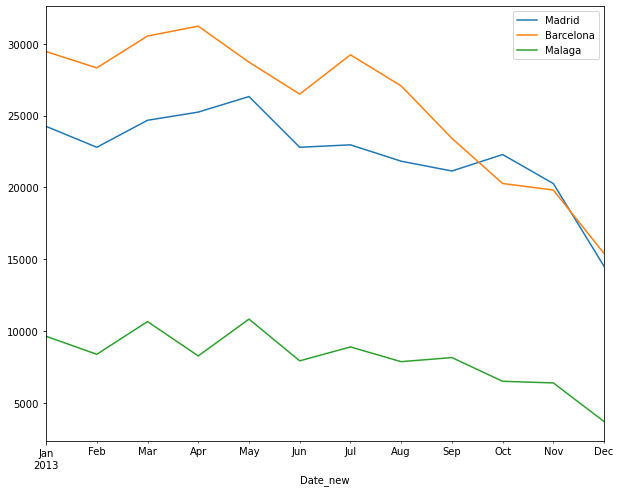

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
grouped.loc['MAD'].plot(ax=ax)
grouped.loc['BCN'].plot(ax=ax)
grouped.loc['AGP'].plot(ax=ax)
plt.legend(['Madrid', 'Barcelona', 'Malaga'])
plt.show()

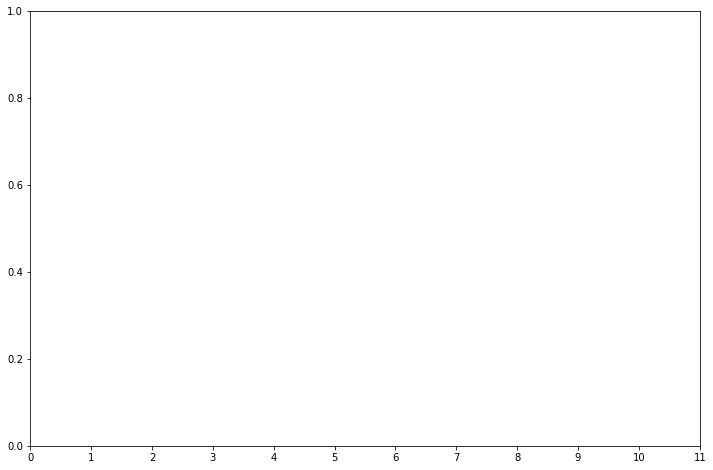

In [30]:
plt.gcf().set_size_inches(12, 8)
plt.gca().set_xticks(range(12))
plt.gca().set_xticks(range(12))

# Exercise 4
Match searches with bookings

• For every search in the searches file, find out whether
the search ended up in a booking or not (using the info
in the bookings file). For instance, search and booking
origin and destination should match.

• For the bookings file, origin and destination are the
columns dep_port and arr_port, respectively.

• Generate a CSV file with the search data, and an
additional field, containing 1 if the search ended up in
a booking, and 0 otherwise.

In [28]:
# bookings --> dep port, arr port 
# searches --> Origin, Destination

In [80]:
bookings_sample.columns = [col.strip() for col in bookings_sample.columns]

In [41]:
bookings_sample.head()

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,...,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,...,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,...,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,...,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,...,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,...,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546


In [42]:
searches_sample.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,...,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,...,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


In [46]:
bookings_sample.columns

Index(['act_date', 'source', 'pos_ctry', 'pos_iata', 'pos_oid', 'rloc',
       'cre_date', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry',
       'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry',
       'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry',
       'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route', 'carrier',
       'bkg_class', 'cab_class', 'brd_time', 'off_time', 'pax', 'year',
       'month', 'oid'],
      dtype='object')

In [44]:
searches_sample.columns

Index(['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin',
       'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure',
       'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode',
       'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier',
       'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date',
       'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival',
       'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure',
       'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode',
       'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier',
       'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet',
       'IsFromVista', 'TerminalID', 'InternetOffice'],
      dtype='object')

In [ ]:
searches_sample['Date'] = bookings_sample['cre_date'] # quitar las horas de bookings
searches_sample['Destination'] = bookings_sample['arr_port']
searches_sample['Origin'] = bookings_sample['dep_port']

In [51]:
searches_sample['Origin']

0        TXL
1        ATH
2        ICT
3        RNB
4        OSL
        ... 
99995    DEL
99996    BUF
99997    JFK
99998    STL
99999    MUC
Name: Origin, Length: 100000, dtype: object

In [52]:
bookings_sample['dep_port']

0        ZRH     
1        SAL     
2        SAL     
3        AKL     
4        AKL     
           ...   
99995    DEL     
99996    DEL     
99997    DEL     
99998    HLA     
99999    HLA     
Name: dep_port, Length: 100000, dtype: object

In [64]:
searches_sample = searches_sample[['Date', 'Destination', 'Origin']]
bookings_sample = bookings_sample[['cre_date', 'arr_port', 'dep_port']]

------------

In [128]:
%%time
df_full = pd.read_csv(
                     bookings_path,
                     compression='bz2', 
                     sep= '^', 
                     header=0, 
                     usecols=['cre_date           ', 'arr_port', 'dep_port']
                    )


CPU times: user 1min 53s, sys: 534 ms, total: 1min 53s
Wall time: 1min 53s


In [135]:
df_full.columns = [col.strip() for col in df_full.columns]
df_full['cre_date'] = df_full['cre_date'].str[:10]

In [136]:
df_full['cre_date']

0           2013-02-22
1           2013-03-26
2           2013-03-26
3           2013-03-26
4           2013-03-26
               ...    
10000005    2013-05-14
10000006    2013-05-14
10000007    2013-05-28
10000008    2013-05-28
10000009    2013-05-28
Name: cre_date, Length: 10000010, dtype: object

searches = pd.read_csv('../../data/challenge/searches_sample.csv', chunksize=10000, parse_dates=True, usecols=['Date', 'Destination', 'Origin'])
bookings = pd.read_csv('../../data/challenge/bookings_sample.csv', chunksize=10000, parse_dates=True, usecols=['cre_date', 'arr_port', 'dep_port'])

In [138]:
searches = pd.read_csv('../../data/challenge/searches_sample.csv', chunksize=10000, parse_dates=True, usecols=['Date', 'Destination', 'Origin'])

In [130]:
df_full.head()

,cre_date,dep_port,arr_port
0,2013-02-22 00:00:00,ZRH,LHR
1,2013-03-26 00:00:00,SAL,CLT
2,2013-03-26 00:00:00,SAL,CLT
3,2013-03-26 00:00:00,AKL,SVO
4,2013-03-26 00:00:00,AKL,SVO


In [139]:
megamerge= []
for chunk in searches:
    minimerge = chunk.merge(df_full, left_on=['Date', 'Origin', 'Destination'], right_on=['cre_date', 'dep_port', 'arr_port'], how='left')
    megamerge.append(minimerge)

: 

: 

In [ ]:
pd.concat(megamerge).reset_index()

,Date,Origin,Destination,cre_date,dep_port,arr_port
0,2013-01-21,OSL,DPS,NaN,NaN,NaN
1,2013-01-21,YYZ,BKK,NaN,NaN,NaN
2,2013-01-21,BEL,SAO,NaN,NaN,NaN
3,2013-01-21,LAX,AMS,NaN,NaN,NaN
4,2013-01-21,LHR,TNR,NaN,NaN,NaN
...,...,...,...,...,...,...
9995,2013-04-10,DEL,TRV,NaN,NaN,NaN
9996,2013-04-10,BUF,AUA,NaN,NaN,NaN
9997,2013-04-10,JFK,KUL,NaN,NaN,NaN
9998,2013-04-10,STL,SEA,NaN,NaN,NaN


--------

megamerge

leer un chunk de searches

last_date searches date.tail(1)
last date bookings date.tail(1)
MERGE
next search
if fecha menor que fecha seguimos
else next bookings

merge con el primero de bookings

s   b
1   1
2   1
3   2
4   3
5   3
6   3



# Exercise 5

Write a Web Service

• Wrap the output of the second exercise in a
web service that returns the data in JSON
format (instead of printing to the standard
output).

• The web service should accept a parameter
n>0. For the top 10 airports, n is 10. For the X
top airports, n is X 